In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import os
path = "/content/drive/MyDrive/code/WZ"
os.chdir(path)
print(os.getcwd())

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/code/WZ'

In [1]:
import importlib
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random

from collections import deque


sizef = 7

In [2]:
class Gomoku:
    def __init__(self, size=sizef, black_strategy=None, white_strategy=None):
        self.size = size  # 棋盘大小
        self.board = [['.' for _ in range(size)] for _ in range(size)]  # 初始化棋盘
        self.current_player = 'X'  # 当前玩家 ('X' or 'O')
        self.black_strategy = black_strategy  # 黑棋策略函数
        self.white_strategy = white_strategy  # 白棋策略函数

    def display_board(self):
        """打印棋盘"""
        print("   " + " ".join(f"{i:2}" for i in range(self.size)))
        for i, row in enumerate(self.board):
            print(f"{i:2} " + " ".join(row))

    def is_valid_move(self, x, y):
        """检查落子是否合法"""
        return 0 <= x < self.size and 0 <= y < self.size and self.board[x][y] == '.'

    def make_move(self, x, y):
        """下棋"""
        if self.is_valid_move(x, y):
            self.board[x][y] = self.current_player
            return True
        else:
            print(f"Invalid move by player {self.current_player} at ({x}, {y}).")
            return False

    def check_winner(self, x, y):
        """检查当前玩家是否获胜"""
        directions = [(1, 0), (0, 1), (1, 1), (1, -1)]  # 四个方向：水平、垂直、正斜线、反斜线
        for dx, dy in directions:
            count = 1
            # 检查正方向
            for step in range(1, 5):
                nx, ny = x + step * dx, y + step * dy
                if 0 <= nx < self.size and 0 <= ny < self.size and self.board[nx][ny] == self.current_player:
                    count += 1
                else:
                    break
            # 检查反方向
            for step in range(1, 5):
                nx, ny = x - step * dx, y - step * dy
                if 0 <= nx < self.size and 0 <= ny < self.size and self.board[nx][ny] == self.current_player:
                    count += 1
                else:
                    break
            if count >= 5:  # 连续五子
                return True
        return False

    def switch_player(self):
        """切换玩家"""
        self.current_player = 'O' if self.current_player == 'X' else 'X'

    def play(self):
        """游戏主循环"""
        print("Starting Gomoku!")
        self.display_board()

        # 检查是否有 GPU 可用
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Running on device: {device}")

        while True:
            if self.current_player == 'X':
                if self.black_strategy:
                    # 将策略函数运行在指定设备上
                    move = self.black_strategy(self.board, 'X', device=device)
                else:
                    move = self.get_human_move()
            else:
                if self.white_strategy:
                    # 将策略函数运行在指定设备上
                    move = self.white_strategy(self.board, 'O', device=device)
                else:
                    move = self.get_human_move()

            if not move or len(move) != 2:
                print(f"Invalid move returned by player {self.current_player}.")
                break

            x, y = move
            if self.make_move(x, y):
                print(f"Player {self.current_player} places at ({x}, {y})")
                self.display_board()
                if self.check_winner(x, y):
                    print(f"Player {self.current_player} wins!")
                    break
                self.switch_player()
            else:
                print("Game Over due to invalid move.")
                break

        print("Game Over!")

    def get_human_move(self):
        """获取玩家的落子"""
        while True:
            try:
                move = input(f"Player {self.current_player}, enter your move (row col): ").strip()
                x, y = map(int, move.split())
                if self.is_valid_move(x, y):
                    return x, y
                else:
                    print("Invalid move. Try again.")
            except ValueError:
                print("Invalid input. Please enter row and column numbers separated by a space.")


def load_strategy(file_name):
    """从本地文件加载策略"""
    if not os.path.exists(file_name):
        raise FileNotFoundError(f"Strategy file {file_name} not found.")

    module_name = os.path.splitext(os.path.basename(file_name))[0]
    spec = importlib.util.spec_from_file_location(module_name, file_name)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    return module.play  # 假设策略文件中定义了一个 play 函数



def print_strategy_files(directory):
    try:
        for root, dirs, files in os.walk(directory):
            for file in files:
                if file.endswith("strategy.py"):
                    print(file)
    except Exception as e:
        print(f"Invaid: {e}")

In [ ]:
print("Welcome to Gomoku!")
print("Choose game mode:")
print("1. Human vs AI")
print("2. AI vs AI")
mode = input("Enter 1 or 2: ").strip()

black_strategy = None
white_strategy = None

if mode == "1":
    print("You will play as 'X'.")
    print_strategy_files(os.getcwd())
    white_strategy_file = input("Enter the AI strategy file for 'O' (e.g., white_strategy.py): ").strip()
    white_strategy = load_strategy(white_strategy_file)
elif mode == "2":
    print_strategy_files(os.getcwd())
    black_strategy_file = input("Enter the AI strategy file for 'X' (e.g., black_strategy.py): ").strip()
    white_strategy_file = input("Enter the AI strategy file for 'O' (e.g., white_strategy.py): ").strip()
    black_strategy = load_strategy(black_strategy_file)
    white_strategy = load_strategy(white_strategy_file)
else:
    print("Invalid choice. Exiting.")

game = Gomoku(black_strategy=black_strategy, white_strategy=white_strategy)
game.play()

In [ ]:
from alpha0v1_strategy import AlphaZeroNet

In [3]:
from alpha0v2_strategy import AlphaZeroNet
from alpha0v2_strategy import MCTS

In [4]:
# ------------------------------
# Data Generation via Self-Play
# ------------------------------
def self_play_game(model, board_size, mcts_simulations=5):
    """Generate training data via self-play"""
    # 检查是否有 GPU 并将模型移动到 GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    board = [['.' for _ in range(board_size)] for _ in range(board_size)]
    mcts = MCTS(model, board_size)
    current_player = 'X'
    mcts_simulations = mcts_simulations
    game_data = []  # Store (state, policy, value) for training
    winner = None

    while True:
        # Run MCTS to get the move and actions
        move, actions = mcts.run(board, current_player, mcts_simulations)

        # Step 1: 提取所有 (action, value_sum) 对
        action_values = [(action, node.value_sum) for action, node in actions.items()]

        # Step 2: 计算所有 value_sum 的 softmax 概率
        values = np.array([value_sum for _, value_sum in action_values])
        exp_values = np.exp(values - np.max(values))  # 减去最大值以稳定计算
        probabilities = exp_values / np.sum(exp_values)

        # Step 3: 生成结果数组
        action_probs = [(action, prob) for (action, _), prob in zip(action_values, probabilities)]

        # Make the move
        board = mcts.make_move(board, move, current_player)

        # Store state and policy
        state = mcts.board_to_tensor(board, current_player).to(device).squeeze(0).detach().cpu().numpy()
        action_probs_np = np.zeros((board_size, board_size))
        for (x, y), prob in action_probs:
            action_probs_np[x, y] = prob

        if mcts.check_winner(board, current_player):
            winner = current_player
            if winner == 'X':
                game_data.append([state, action_probs_np, current_player, 1])
            else:
                game_data.append([state, action_probs_np, current_player, -1])
            break
        if not mcts.get_legal_moves(board):
            winner = None  # Draw
            game_data.append([state, action_probs_np, current_player, 0])
            break
        current_player = 'O' if current_player == 'X' else 'X'

    return game_data

In [5]:
def compute_softmax_probabilities(children):
    # Step 1: 提取所有 (action, value_sum) 对
    action_values = [(action, node.value_sum) for action, node in children.items()]

    # Step 2: 计算所有 value_sum 的 softmax 概率
    values = np.array([value_sum for _, value_sum in action_values])
    exp_values = np.exp(values - np.max(values))
    probabilities = exp_values / np.sum(exp_values)

    # Step 3: 生成结果数组
    result = [(action, prob) for (action, _), prob in zip(action_values, probabilities)]
    return result




In [6]:
def train_alphazero(model, board_size, iterations=100, games_per_iteration=10, 
                    batch_size=32, mcts_simulations=100, alpha=0.5, l2_lambda=1e-4, entropy_alpha=1e-3):
    """Train AlphaZero model"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Move model to GPU if available
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
    replay_buffer = deque(maxlen=10000)  # Replay buffer to store training data
    loss_fn_policy = nn.CrossEntropyLoss()
    loss_fn_value = nn.MSELoss()

    policy_loss_list = []
    value_loss_list = []

    for iteration in range(iterations):

        # Generate self-play data
        for _ in range(games_per_iteration):
            game_data = self_play_game(model, board_size, mcts_simulations)
            replay_buffer.extend(game_data)

        # Sample a batch from replay buffer
        if len(replay_buffer) < batch_size:
            continue

        batch = random.sample(replay_buffer, batch_size)
        states, policies, _, values = zip(*batch)

        # Move data to GPU
        states = torch.tensor(np.stack(states), dtype=torch.float32).to(device)
        policies = torch.tensor(np.stack(policies), dtype=torch.float32).view(batch_size, 
                                                        board_size * board_size).to(device)
        values = torch.tensor(values, dtype=torch.float32).view(-1, 1).to(device)

        # Forward pass
        pred_policies, pred_values = model(states)

        # Compute losses
        policy_loss = loss_fn_policy(pred_policies, policies)
        value_loss = loss_fn_value(pred_values, values)

        l2_reg = sum(param.pow(2).sum() for param in model.parameters())
        entropy = -torch.sum(pred_policies * torch.log(pred_policies + 1e-8), dim=1).mean()

        loss = (policy_loss * alpha + value_loss * (1 - alpha)
                + l2_lambda * l2_reg
                - entropy_alpha * entropy)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        policy_loss_list.append(policy_loss.item())
        value_loss_list.append(value_loss.item())

        print(f"Iteration {iteration + 1}/{iterations}")
        print(f"Policy Loss: {policy_loss.item():.4f}, Value Loss: {value_loss.item():.4f}")

    # Save model weights
    torch.save(model.state_dict(), "alphazero_weights.pth")
    print("Training complete. Weights saved to 'alphazero_weights.pth'.")

    return policy_loss_list, value_loss_list

In [7]:
board_size = 7
model = AlphaZeroNet(board_size)



policy_loss, value_loss = train_alphazero(
                        model=model,
                        board_size=board_size,
                        iterations=2000,
                        games_per_iteration=5,
                        batch_size=16,
                        mcts_simulations=20,
                        alpha=0.9
                    )

Using device: cpu
<U1
Board content:
[['.' '.' '.' '.' '.' '.' '.']
 ['.' '.' '.' '.' '.' '.' '.']
 ['.' '.' '.' '.' '.' '.' '.']
 ['.' '.' '.' '.' '.' '.' '.']
 ['.' '.' '.' '.' '.' '.' '.']
 ['.' '.' '.' '.' '.' '.' '.']
 ['.' '.' '.' '.' '.' '.' '.']]
<U1
Board content:
[['.' '.' '.' '.' '.' '.' '.']
 ['.' '.' '.' '.' '.' '.' '.']
 ['.' '.' '.' '.' '.' '.' '.']
 ['.' '.' '.' '.' '.' '.' '.']
 ['.' '.' '.' '.' '.' '.' '.']
 ['.' '.' '.' '.' '.' '.' '.']
 ['.' '.' '.' '.' '.' '.' '.']]
<U1
Board content:
[['.' '.' '.' '.' '.' '.' '.']
 ['.' '.' '.' '.' '.' '.' '.']
 ['.' '.' '.' '.' '.' '.' '.']
 ['.' '.' '.' '.' '.' '.' '.']
 ['.' '.' '.' '.' '.' '.' '.']
 ['.' '.' '.' '.' '.' '.' '.']
 ['.' '.' '.' '.' '.' '.' '.']]
<U1
Board content:
[['.' '.' '.' '.' '.' '.' '.']
 ['.' '.' '.' '.' '.' '.' '.']
 ['.' '.' '.' '.' '.' '.' '.']
 ['.' '.' '.' '.' '.' '.' '.']
 ['.' '.' '.' '.' '.' '.' '.']
 ['.' '.' '.' '.' '.' '.' '.']
 ['.' '.' '.' '.' '.' '.' '.']]
<U1
Board content:
[['.' '.' '.' '

AttributeError: 'list' object has no attribute 'dtype'

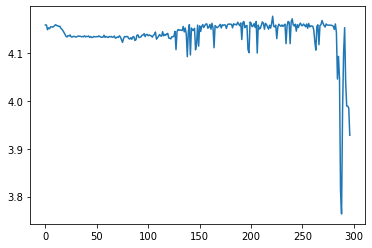

In [9]:
import matplotlib.pyplot as plt

plt.plot(policy_loss)
plt.show()

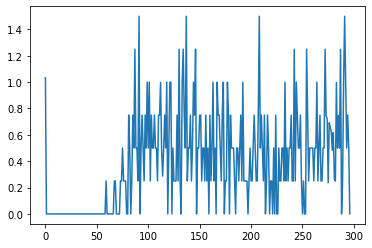

In [10]:
plt.plot(value_loss)
plt.show()